In [134]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss

x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)
p1 = ss.expon(scale=3)
p2 = ss.expon(scale=10)

M = p1.pdf(x).reshape(1, -1) * p2.pdf(y).reshape(-1, 1)

Text(0.5, 0.92, '$Exp(3), Exp(10)$ prior landscape; \nalternate view')

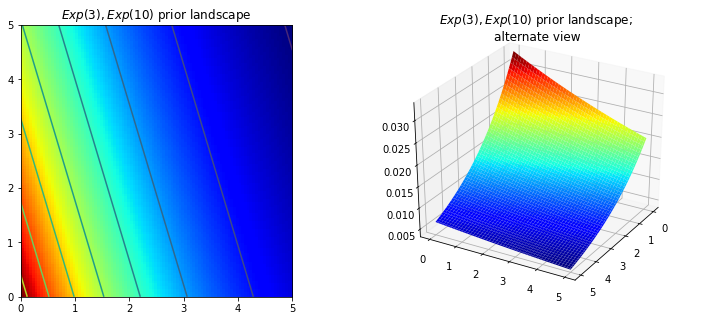

In [136]:
fig = plt.figure(figsize=(12.5, 5))
plt.subplot(121)
plt.contour(X, Y, M)
im = plt.imshow(M, interpolation="None", origin="lower", cmap="jet", extent=(0, 5, 0, 5))
plt.title("$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection="3d")
ax.plot_surface(X, Y, M, cmap="jet")
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ prior landscape; \nalternate view")

### 由一个观测点引起的后验分布变化

已知数据生成自未知的泊松分布

In [116]:
lambda_x_true = 1
lambda_y_true = 3
p1 = ss.poisson(mu=lambda_x_true)  # 未知参数
p2 = ss.poisson(mu=lambda_y_true)  # 未知参数
def generate_obs(n: int):
    x = p1.rvs(size=(n, 1))
    y = p2.rvs(size=(n, 1))
    return np.concatenate([x, y], axis=1)

In [122]:
data = generate_obs(1)
x = y = np.linspace(0.01, 5, 50)
print(data[0])

[1 2]


In [137]:
likelihood_x = np.array([ss.poisson.pmf(data[:, 0], mu=_x) for _x in x]).prod(axis=1)
likelihood_y = np.array([ss.poisson.pmf(data[:, 1], mu=_y) for _y in y]).prod(axis=1)
L = likelihood_x.reshape(1, -1) * likelihood_y.reshape(-1, 1)

In [105]:
# 不同的先验分布
distributions = {
    "Uniform": (ss.uniform(loc=0, scale=5), ss.uniform(loc=0, scale=5)), 
    "Exponential": (ss.expon(scale=3), ss.expon(scale=10))
}

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: No contour levels were found within the data range.
  import sys


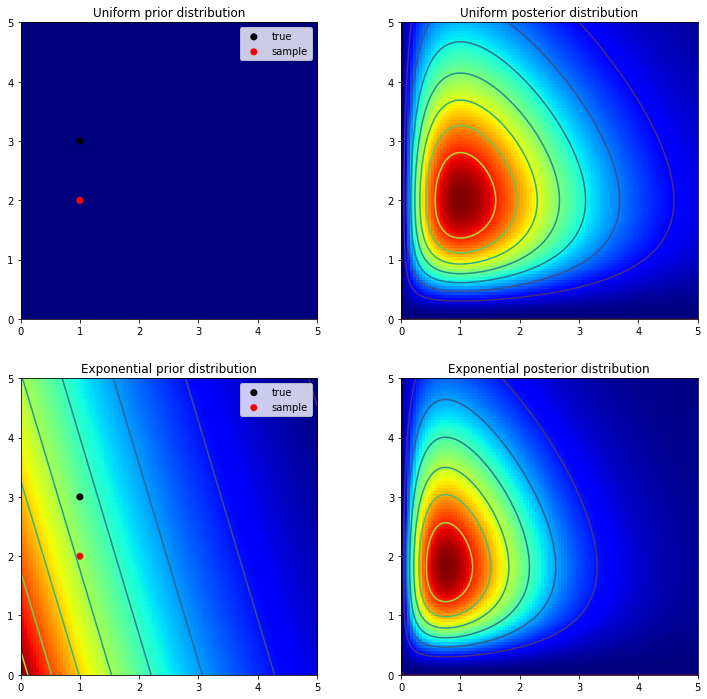

In [171]:
fig, axes = plt.subplots(figsize=(12.5, 12), nrows=len(distributions), ncols=2)

for i, (distr_type, (distr_x, distr_y)) in enumerate(distributions.items()):
    # 先验分布
    ax = axes[i, 0]
    M = distr_x.pdf(x).reshape(1, -1) * distr_y.pdf(y).reshape(-1, 1)
    ax.contour(x, y, M)
    ax.imshow(M, interpolation="none", origin="lower", cmap="jet", extent=[0, 5, 0, 5])
    ax.set_title(f"{distr_type} prior distribution")
    
    # 真实分布点
    ax.scatter(lambda_x_true, lambda_y_true, c="k", s=50, edgecolors="none", label="true")
    # 实际分布点
    ax.scatter(*data[0], c="red", s=50, edgecolors="none", label="sample")
    ax.legend(loc="upper right")
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    
    # 后验分布
    ax = axes[i, 1]
    ax.contour(x, y, M * L)
    ax.imshow(M * L, interpolation="none", origin="lower", cmap="jet", extent=[0, 5, 0, 5])
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    ax.set_title(f"{distr_type} posterior distribution")
    

### 实例：使用混合模型进行无监督聚类

[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136]


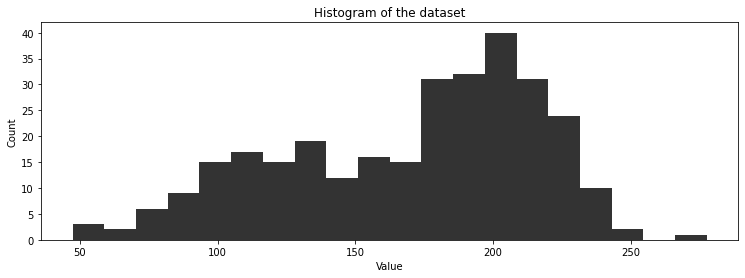

In [174]:
data = np.loadtxt("data/mixture_data.csv", delimiter=",")

plt.figure(figsize=(12.5, 4))
plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.ylim(0, None)
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Histogram of the dataset")
print(data[:10])

认为数据是由两个正态分布独立生成的

C:\ProgramData\Anaconda3\lib\site-packages\pymc\MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 50000 of 50000 complete in 14.0 secPlotting centers_0
Plotting centers_1
Plotting p
Plotting stds_0
Plotting stds_1


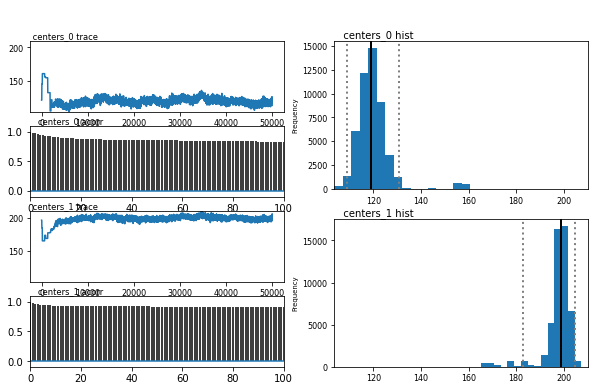

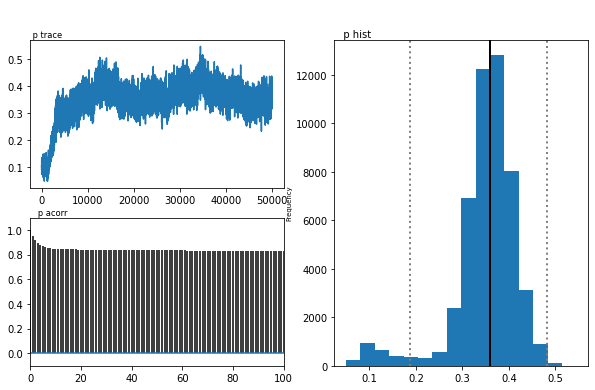

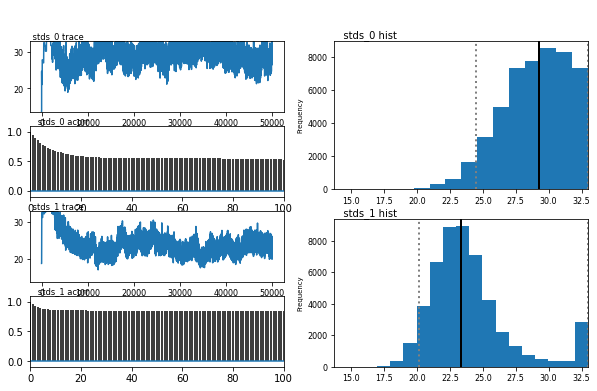

In [268]:
import pymc as pm
from pymc.Matplot import plot as mcplot

centers = pm.Normal("centers", mu=[120, 190], tau=[0.01, 0.01], size=2)
stds = pm.Uniform("stds", 0., 33., size=2)
taus = 1.0 / stds ** 2

p = pm.Uniform("p", 0.0, 1.0)
assignment = pm.Categorical("assignment", p=[p, 1 - p], size=len(data))

@pm.deterministic
def center(assignment=assignment, centers=centers):
    return centers[assignment]

@pm.deterministic
def tau(assignment=assignment, taus=taus):
    return taus[assignment]
    
observations = pm.Normal("obs", mu=center, tau=tau, value=data, observed=True)

model = pm.Model([observations, centers, stds, p, assignment])
mcmc = pm.MCMC(model)
mcmc.sample(50000)
mcplot(mcmc)

In [270]:
colors = ["#348ABD", "#A60628"]

中心点的迹

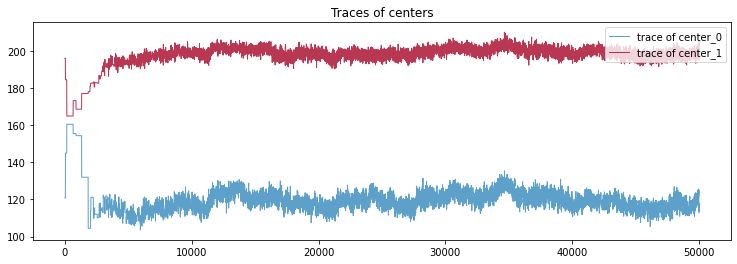

In [282]:
center_trace = mcmc.trace("centers")[:]
plt.figure(figsize=(12.5, 4))
for i in range(2):
    plt.plot(center_trace[:, i], label=f"trace of center_{i}", color=colors[i], lw=1, alpha=0.8)
plt.title("Traces of centers")
plt.legend(loc="upper right")

标准差的迹

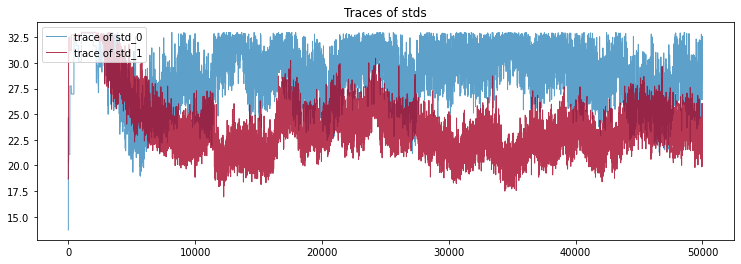

In [283]:
std_trace = mcmc.trace("stds")[:]
plt.figure(figsize=(12.5, 4))
for i in range(2):
    plt.plot(std_trace[:, i], label=f"trace of std_{i}", color=colors[i], lw=1, alpha=0.8)
plt.title("Traces of stds")
plt.legend(loc="upper left")

赋值概率$P$的迹

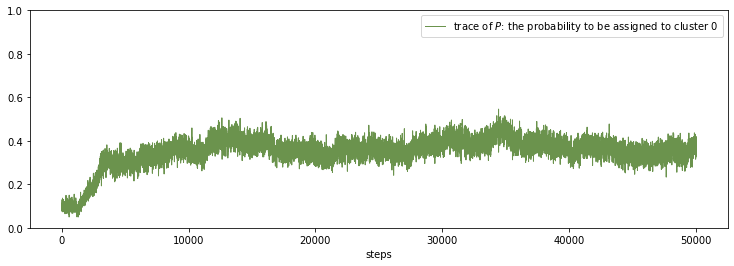

In [280]:
p_trace = mcmc.trace("p")[:]
plt.figure(figsize=(12.5, 4))
plt.plot(p_trace, label="trace of $P$: the probability to be assigned to cluster 0", 
         color="#467821", lw=1, alpha=0.8)
plt.xlabel("steps")
plt.ylim(0, 1)
plt.legend()

各数据点属于cluster0的概率

In [286]:
import matplotlib as mpl
colors = ["#348ABD", "#A60628"]
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = mcmc.trace("assignment")[:]

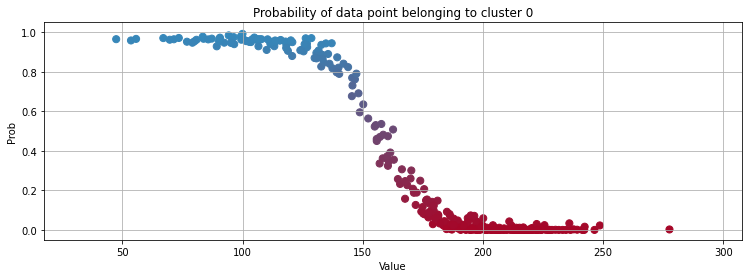

In [288]:
plt.figure(figsize=(12.5, 4))
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap, c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(data.min() - 30, data.max() + 30)
plt.title("Probability of data point belonging to cluster 0")
plt.xlabel("Value")
plt.ylabel("Prob")
plt.grid()